# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc
)

from imblearn.over_sampling import SMOTE


# Load Dataset

In [ ]:
data = pd.read_csv("heart.csv")
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Feature / Target Split

In [ ]:
X = data.iloc[:, :13].values   # First 13 columns as features
y = data["target"].values      # Target column


# Train-Test Split (with stratification)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Original dataset distribution:", Counter(y))
print("Train distribution before SMOTE:", Counter(y_train))
print("Test distribution:", Counter(y_test))


Original dataset distribution: Counter({np.int64(1): 165, np.int64(0): 138})
Train distribution before SMOTE: Counter({np.int64(1): 115, np.int64(0): 97})
Test distribution: Counter({np.int64(1): 50, np.int64(0): 41})


# Apply SMOTE to handle imbalance

After SMOTE (train set): Counter({np.int64(1): 115, np.int64(0): 115})


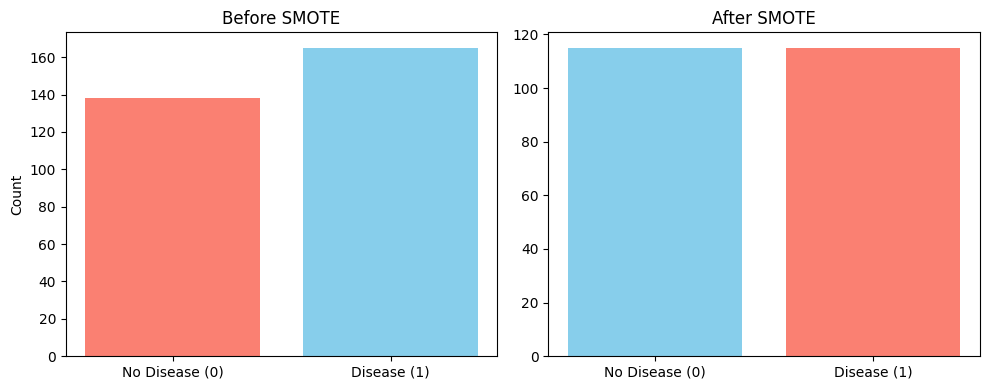

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE (train set):", Counter(y_train))

# Plot Before vs After SMOTE
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].bar(Counter(y).keys(), Counter(y).values(), color=['skyblue','salmon'])
axs[0].set_title("Before SMOTE")
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(["No Disease (0)", "Disease (1)"])
axs[0].set_ylabel("Count")

axs[1].bar([0,1], np.bincount(y_train), color=['skyblue','salmon'])
axs[1].set_title("After SMOTE")
axs[1].set_xticks([0,1])
axs[1].set_xticklabels(["No Disease (0)", "Disease (1)"])

plt.tight_layout()
plt.show()


# Feature Scaling

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Build Neural Network Model

In [ ]:
classifier = Sequential([
    Dense(units=8, activation="relu", input_dim=13, kernel_initializer="he_uniform"),
    Dense(units=14, activation="relu", kernel_initializer="he_uniform"),
    Dense(units=1, activation="sigmoid")
])

classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 14)             │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

# Train Model with Early Stopping

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = classifier.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=8,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3683 - loss: 0.7820 - val_accuracy: 0.4565 - val_loss: 0.7539
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4973 - loss: 0.7041 - val_accuracy: 0.6087 - val_loss: 0.6875
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6055 - loss: 0.6510 - val_accuracy: 0.6522 - val_loss: 0.6458
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6643 - loss: 0.6511 - val_accuracy: 0.7609 - val_loss: 0.6109
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7435 - loss: 0.6048 - val_accuracy: 0.7826 - val_loss: 0.5883
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.5632 - val_accuracy: 0.7826 - val_loss: 0.5610
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7955 - loss: 0.5097 - val_accuracy: 0.7826 - val_loss: 0.5387
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7386 - loss: 0.5518 - val_accuracy: 0.7826 - 

# Training Curves

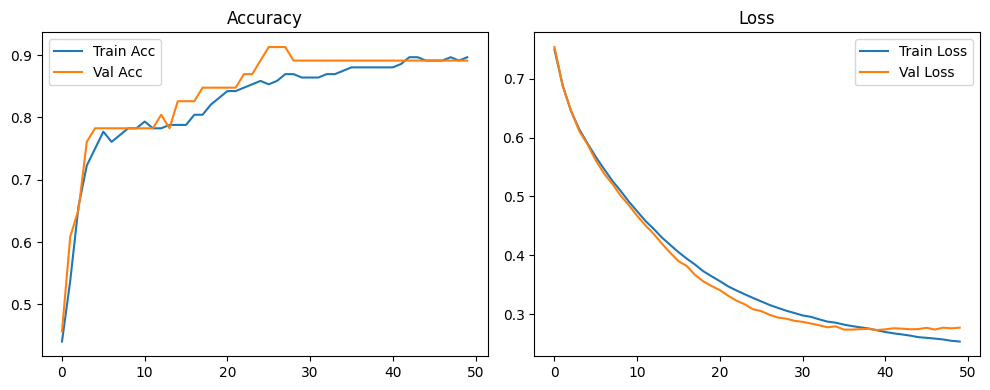

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.tight_layout()
plt.show()


# Evaluate on Test Set

In [ ]:
y_pred_prob = classifier.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy manually
accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Confusion Matrix:
 [[27 14]
 [12 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.68        41
           1       0.73      0.76      0.75        50

    accuracy                           0.71        91
   macro avg       0.71      0.71      0.71        91
weighted avg       0.71      0.71      0.71        91

Test Accuracy: 71.43%


# ROC Curve & AUC

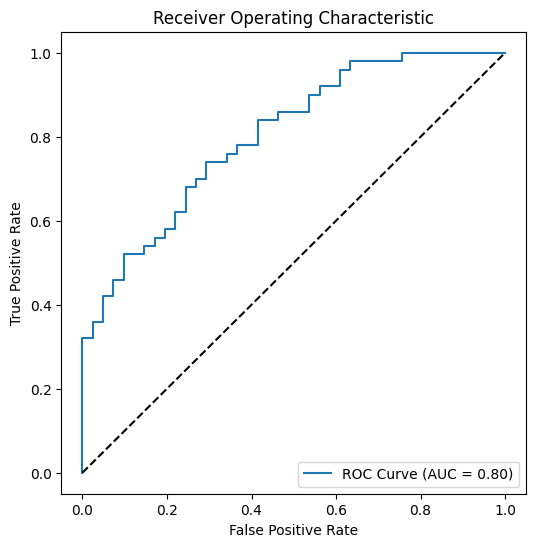

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

def evaluate_model(y_true, y_pred, title="Model"):
    print(f"\n===== {title} =====")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))

    # Confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
    plt.title(f"{title} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


# -------------------------------
# OLD MODEL (No SMOTE)
# -------------------------------

In [ ]:
from sklearn.preprocessing import StandardScaler

# Train-test split (no resampling)
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Scale features
sc_old = StandardScaler()
X_train_old = sc_old.fit_transform(X_train_old)
X_test_old = sc_old.transform(X_test_old)

# Build model
old_model = Sequential()
old_model.add(Dense(8, activation="relu", input_dim=13, kernel_initializer="uniform"))
old_model.add(Dense(14, activation="relu", kernel_initializer="uniform"))
old_model.add(Dense(1, activation="sigmoid", kernel_initializer="uniform"))
old_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train
old_model.fit(X_train_old, y_train_old, batch_size=8, epochs=50, verbose=0)

# Predictions
y_pred_old = (old_model.predict(X_test_old) > 0.5).astype(int)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


In [ ]:
y_pred_new = (classifier.predict(X_test) > 0.5).astype(int)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



===== Old Model (No SMOTE) =====
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        41
           1       0.88      0.86      0.87        50

    accuracy                           0.86        91
   macro avg       0.86      0.86      0.86        91
weighted avg       0.86      0.86      0.86        91

ROC-AUC: 0.8568292682926828


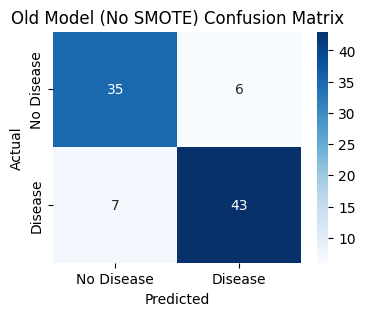


===== New Model (SMOTE) =====
              precision    recall  f1-score   support

           0       0.69      0.66      0.68        41
           1       0.73      0.76      0.75        50

    accuracy                           0.71        91
   macro avg       0.71      0.71      0.71        91
weighted avg       0.71      0.71      0.71        91

ROC-AUC: 0.7092682926829268


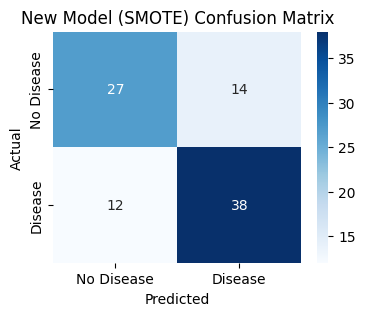

In [ ]:
evaluate_model(y_test_old, y_pred_old, "Old Model (No SMOTE)")
evaluate_model(y_test, y_pred_new, "New Model (SMOTE)")
